# Gather Historical ETF Data 

In [1]:
import os
from copy import deepcopy
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from yahoofinancials import YahooFinancials

## Data Download

In [2]:
granularity_interval = '15m'
tickers = 'XBB.TO XINC.TO XCNS.TO XBAL.TO XGRO.TO XEQT.TO VAB.TO VCIP.TO VCNS.TO VBAL.TO VGRO.TO VEQT.TO'

In [3]:
ticker_data_filepath = f'data/ticker_data_{granularity_interval}.csv'
tickers_list = tickers.split()
today = datetime.now()

# increment size and start date are limited by Yahoo Finance according to granularity_interval
query_limits = {
    '1m': {
        'start_date': 30,
        'increment_size': 7
    },
    '2m': {
        'start_date': 60,
        'increment_size': 60
    },
    '5m': {
        'start_date': 60,
        'increment_size': 60
    },
    '15m': {
        'start_date': 60,
        'increment_size': 60
    },
    '30m': {
        'start_date': 60,
        'increment_size': 60
    },
    '60m': {
        'start_date': 730,
        'increment_size': 730
    }
}
start_date = query_limits[granularity_interval]['start_date']
increment_size = query_limits[granularity_interval]['increment_size']

In [4]:
# minute-by-minute data is only available within the last 30 days
start_date = today - timedelta(days=start_date - 1)

# initialize ticker data storage
ticker_df = pd.DataFrame()

# iterate from inception date to today. yfinance takes care of end_date conditions if we go past current day.
while start_date < today:
    end_date = start_date + timedelta(days=increment_size - 1)
    ticker_df = ticker_df.append(yf.download(tickers=tickers, 
                                             start=start_date.strftime('%Y-%m-%d'),
                                             end=end_date.strftime('%Y-%m-%d'),
                                             interval=granularity_interval,
                                             progress=False))
    start_date = end_date + timedelta(days=1)

In [5]:
# if granuality_interval is short enough (~15 minutes or less), can assume one column represents both the high and low
ticker_df = ticker_df['Adj Close']
ticker_df = ticker_df.rename(columns={'Adj Close': 'Price'})

# round to 2 decimal places
ticker_df = ticker_df.round(2)

# name index column
ticker_df.index.name = 'Datetime'

# persist data
save_headers = not os.path.exists(ticker_data_filepath)
ticker_df.to_csv(ticker_data_filepath, mode='a', header=save_headers)

False


#### Start Here to Skip Data Download 

In [6]:
# load all gathered data for analysis
full_ticker_df = pd.read_csv(ticker_data_filepath)

# drop duplicates from the same minute
full_ticker_df.drop_duplicates(subset='Datetime', inplace=True)

In [7]:
# extract date information from index for easier analysis
def extract_time(string_timestamp):
    if ":" == string_timestamp[-3:-2]:
        string_timestamp = string_timestamp[:-3] + string_timestamp[-2:]
    timestamp = datetime.strptime(string_timestamp, "%Y-%m-%d %H:%M:%S%z")
    return pd.Series((timestamp, timestamp.strftime('%Y'), timestamp.strftime("%Y-%m-%d"), timestamp.strftime('%U'), timestamp.strftime('%H%M'), timestamp.strftime('%w')))

full_ticker_df[['Datetime', 'unique_year', 'unique_day', 'week_of_year', 'time_of_day', 'day_of_week']] = full_ticker_df["Datetime"].apply(lambda timestamp: extract_time(timestamp))

## Find Peaks of Daily Prices

In [8]:
peak_daily_values = full_ticker_df.groupby(['unique_day']).max()

peak_daily_values_df = full_ticker_df.copy()
peak_daily_values_df[tickers_list] = np.nan

for unique_day, row in peak_daily_values.iterrows():
    for ticker in tickers_list:
        # find the locations of the max values in the original dataframe
        peak_indices = full_ticker_df[(full_ticker_df['unique_day'] == unique_day) & (full_ticker_df[ticker] == row[ticker])].index
        
        # place a value in the indices where peak values occurred
        for peak_index in peak_indices:
            peak_daily_values_df.at[peak_index, ticker] = 1 / len(peak_indices) if len(peak_indices) else np.nan

In [9]:
peak_time_df = pd.DataFrame(index=peak_daily_values_df['time_of_day'].unique(), columns=tickers_list)

for time in peak_time_df.index:
    for ticker in tickers_list:
        peak_time_df.at[time, ticker] = peak_daily_values_df[peak_daily_values_df['time_of_day'] == time][ticker].sum() / peak_daily_values[ticker].sum()

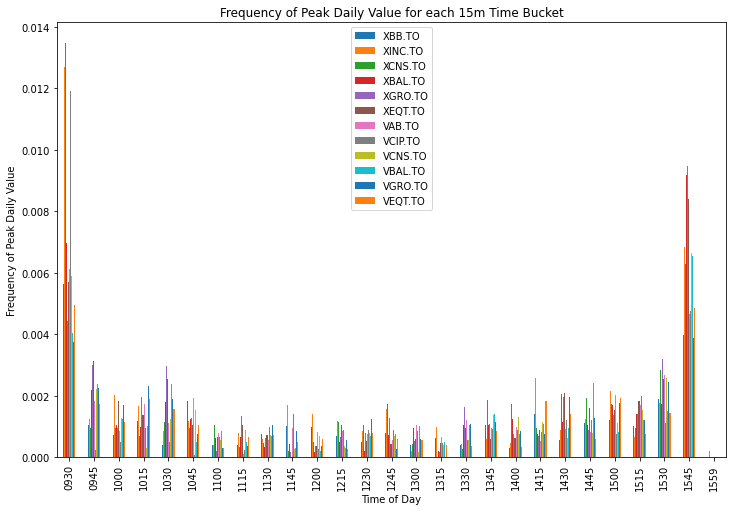

In [10]:
peak_time_df.plot.bar(figsize=(12, 8), title=f'Frequency of Peak Daily Value for each {granularity_interval} Time Bucket')
plt.xlabel('Time of Day')
plt.ylabel('Frequency of Peak Daily Value')
plt.show()

# Find Troughs of Daily Prices

In [11]:
trough_daily_values = full_ticker_df.groupby(['unique_day']).min()

trough_daily_values_df = full_ticker_df.copy()
trough_daily_values_df[tickers_list] = np.nan

for unique_day, row in trough_daily_values.iterrows():
    for ticker in tickers_list:
        # find the locations of the min values in the original dataframe
        trough_indices = full_ticker_df[(full_ticker_df['unique_day'] == unique_day) & (full_ticker_df[ticker] == row[ticker])].index
        
        # place a value in the indices where peak values occurred
        for trough_index in trough_indices:
            trough_daily_values_df.at[trough_index, ticker] = 1 / len(trough_indices) if len(trough_indices) else np.nan

In [12]:
trough_time_df = pd.DataFrame(index=trough_daily_values_df['time_of_day'].unique(), columns=tickers_list)

for time in trough_time_df.index:
    for ticker in tickers_list:
        trough_time_df.at[time, ticker] = trough_daily_values_df[trough_daily_values_df['time_of_day'] == time][ticker].sum() / trough_daily_values_df[ticker].sum()

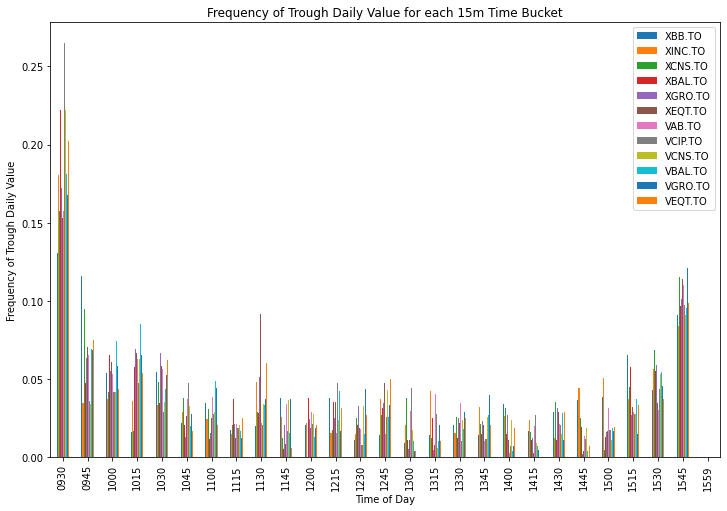

In [13]:
trough_time_df.plot.bar(figsize=(12, 8), 
                        title=f'Frequency of Trough Daily Value for each {granularity_interval} Time Bucket')
plt.xlabel('Time of Day')
plt.ylabel('Frequency of Trough Daily Value')
plt.show()

# Find Peaks of Weekly Prices

In [14]:
peak_weekly_values = full_ticker_df.groupby(['unique_year', 'week_of_year']).max()

peak_weekly_values_df = full_ticker_df.copy()
peak_weekly_values_df[tickers_list] = np.nan

for unique_year_and_week, row in peak_weekly_values.iterrows():
    for ticker in tickers_list:
        # find the locations of the max values in the original dataframe
        peak_indices = full_ticker_df[(full_ticker_df['unique_year'] == unique_year_and_week[0]) & (full_ticker_df['week_of_year'] == unique_year_and_week[1]) & (full_ticker_df[ticker] == row[ticker])].index
        
        # place a value in the indices where peak values occurred
        for peak_index in peak_indices:
            peak_weekly_values_df.at[peak_index, ticker] = 1 / len(peak_indices) if len(peak_indices) else np.nan

In [15]:
peak_day_df = pd.DataFrame(index=['1', '2', '3', '4', '5'], columns=tickers_list)

for day in peak_day_df.index:
    for ticker in tickers_list:
        peak_day_df.at[day, ticker] = peak_weekly_values_df[peak_weekly_values_df['day_of_week'] == day][ticker].sum() / peak_weekly_values_df[ticker].sum()

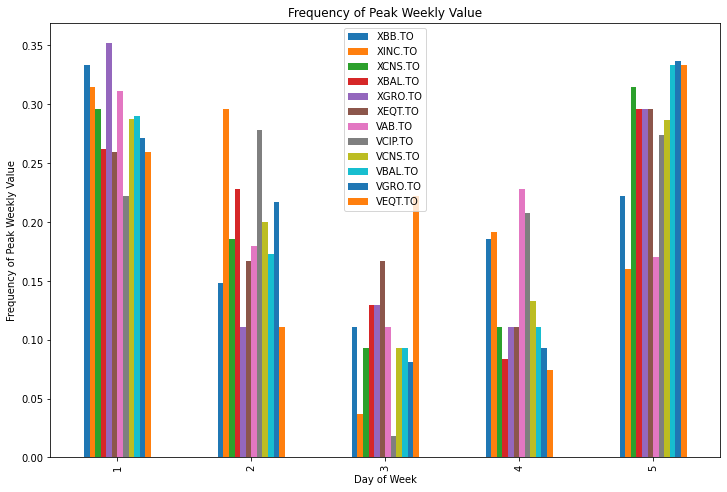

In [16]:
peak_day_df.plot.bar(figsize=(12, 8), title='Frequency of Peak Weekly Value')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Peak Weekly Value')
plt.show()

# Find Troughs of Weekly Prices

In [17]:
trough_weekly_values = full_ticker_df.groupby(['unique_year', 'week_of_year']).min()

trough_weekly_values_df = full_ticker_df.copy()
trough_weekly_values_df[tickers_list] = np.nan

for unique_year_and_week, row in trough_weekly_values.iterrows():
    for ticker in tickers_list:
        # find the locations of the min values in the original dataframe
        trough_indices = full_ticker_df[(full_ticker_df['unique_year'] == unique_year_and_week[0]) & (full_ticker_df['week_of_year'] == unique_year_and_week[1]) & (full_ticker_df[ticker] == row[ticker])].index
        
        # place a value in the indices where peak values occurred
        for trough_index in trough_indices:
            trough_weekly_values_df.at[trough_index, ticker] = 1 / len(trough_indices) if len(trough_indices) else np.nan

In [18]:
trough_day_df = pd.DataFrame(index=['1', '2', '3', '4', '5'], columns=tickers_list)

for day in trough_day_df.index:
    for ticker in tickers_list:
        trough_day_df.at[day, ticker] = trough_weekly_values_df[trough_weekly_values_df['day_of_week'] == day][ticker].sum() / trough_weekly_values_df[ticker].sum()

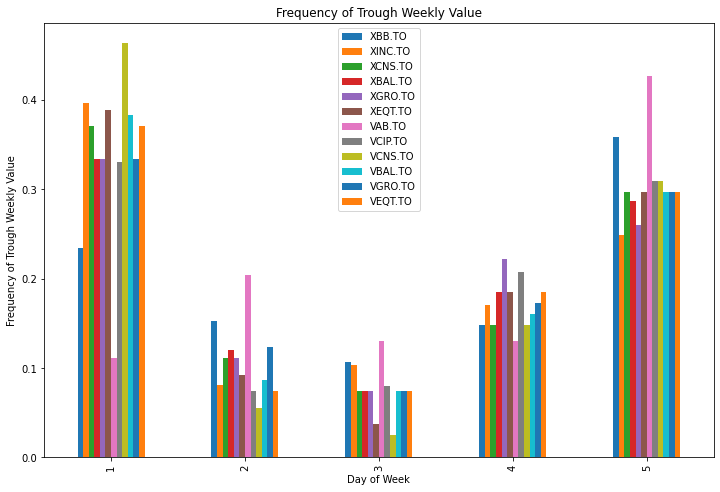

In [19]:
trough_day_df.plot.bar(figsize=(12, 8), title='Frequency of Trough Weekly Value')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Trough Weekly Value')
plt.show()

### Useful Tidbits

In [20]:
# fetch inception date of ticker
# inception_date  = yf.download(tickers=ticker, period='max').index[0]